In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/My\ Drive/SRA_Project/"

In [ ]:
# go to the folder:
%cd /content/gdrive/My\ Drive/SRA_Project/
# print out the content of the folder:
%ls


/content/gdrive/My Drive/SRA_Project
Densenet121_model.pt               Squeezenet_model.pt
Densenet121_updated_model.pt       Squeezenet_updated_model.pt
Driveable_Classification_Dataset/  Terrain_Classification_Dataset/
Driveable_Dataset/                 Test.txt
Googlenet_model.pt                 Train.txt
Googlenet_updated_model.pt         Updated_Driveable_Classification_Dataset/
Resnet18_model.pt                  Updated_Terrain_Classification_Dataset/
Resnet18_updated_base_model.pt     Vgg16_updated_model.pt
Resnet18_updated_model.pt          Vgg19_model.pt
Resnext50_model.pt                 Wide_resnet50_updated_model.pt
Resnext50_updated_model.pt


In [ ]:
from glob import glob

terrain_label_map = {"Dirt":"0","Muddy":"1","Normal":"2","Rocky":"3","Sandy":"4", "Snowy":"5","Wet":"6"}
driveable_label_map = {"Driveable":"1", "Non-Driveable":"0"}

def folder_to_txt(split = "Train"):

  print("Working on " + split + " txt file...")
  # empty string to keep track of the data:
  txt = ""

  # get the list of terrain folders inside the current "split folder":
  terrain_list = glob("./Updated_Terrain_Classification_Dataset/" + split + "/*")
  n_categories = len(terrain_list)

  driveable_list = glob("./Driveable_Dataset/Driveable/*")
  not_driveable_list = glob("./Driveable_Dataset/NotDriveable/*")

  img_count = 0

  # enumerate through the terrain folders:
  for i, folder_name in enumerate(terrain_list):

    # get list of images in the current terrain folder:
    img_list = glob(f"{folder_name}/*")
    n_images = len(img_list)

    # find terrain label
    terrain_type = folder_name.split("/")[-1]
    terrain_label = terrain_label_map[terrain_type]

    # save information on the images into the text file
    for img in img_list:
      img_name = img.split("/")[-1]

      # find driveability label
      if any(img_name in s for s in driveable_list):
        driveable_label = 1
      elif any(img_name in s for s in not_driveable_list):
        driveable_label = 0
      else:
        continue

      txt += f"{img}|{terrain_label}|{driveable_label}\n"
      img_count += 1
  
  # save all information to a text file
  print(f"Saving {split}...")
  txt_file = open(f"./{split}.txt","w+")
  txt_file.writelines(txt) 
  txt_file.close()
  print(f"{split} saved")
  print(f"Number of images: {img_count}\n")

folder_to_txt("Train")
folder_to_txt("Test")

Working on Train txt file...
Saving Train...
Train saved
Number of images: 309

Working on Test txt file...
Saving Test...
Test saved
Number of images: 83



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models


import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# data transforms:
data_transforms = {
    "train": transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(10),
      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Create your custom dataset below:
class Sky_Dataset(Dataset):
    
    def __init__(self, txt, transform=None):
        # prepare two lists where we will keep track of image paths and their labels
        self.img_path = []
        self.tlabels = []
        self.dlabels = []
        self.transform = transform

        # read the txt file into our empty lists:
        with open(txt) as f:
            for line in f:
                # TO BE IMPLEMENTED
                # Append correct information to the lists.
                # self.img_path should contain only paths to images (as strings)
                # self.labels should contain labes (as integers)
                line = line.split("|")
                self.img_path.append(line[0])
                self.tlabels.append(int(line[1]))
                self.dlabels.append(int(line[2]))

        # let's convert the list to a numpy array        
        self.tlabels = np.asarray(self.tlabels)
        self.dlabels = np.asarray(self.dlabels)
        
    def __len__(self):
        return len(self.tlabels)


    def __getitem__(self, index):
        # get the path and label of an image at index 'index'
        path = self.img_path[index]
        tlabel = self.tlabels[index]
        dlabel = self.dlabels[index]

        # open image 1:
        with open(path, 'rb') as f:
            image1 = Image.open(f).convert('RGB')
        if self.transform is not None:
            image1 = self.transform(image1)
        return image1, tlabel, dlabel

In [ ]:
batch_size = 16
num_workers = 0

train_data = Sky_Dataset("./Train.txt", data_transforms["train"])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

test_data = Sky_Dataset("./Test.txt", data_transforms["test"])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)



In [ ]:
# define model
# create our own network:
class SkyNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = models.wide_resnet50_2(pretrained = True)
        self.net.fc1 = nn.Linear(in_features = 1000, out_features = 7)
        self.net.fc2 = nn.Linear(in_features = 1000, out_features = 2)

    def forward(self, x1):
        x1  = self.net(x1)
        out1 = self.net.fc1(x1)
        out2 = self.net.fc2(x1)
        return out1, out2

In [ ]:
"""Train (and validate):"""
# initialize the model:
model = SkyNet()
print(model)

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
# specify scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# number of epochs to train the model
n_epochs = 20

n_iterations = int(len(train_data)/batch_size)

test_accuracies_t = []
test_accuracies_d = []
train_loss_progress = []


for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    model.train() # prep model for training

    ###################
    # train the model #
    ###################
    for iter, (data, target_t, target_d) in enumerate(train_loader):  

        print("Epoch:", epoch, "Iteration:", iter, "out of:", n_iterations)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # forward pass: compute predicted outputs by passing inputs to the model
        outputs_t, outputs_d = model(data)

        # calculate the loss
        loss_t = criterion(outputs_t, target_t)
        loss_d = criterion(outputs_d, target_d)
        loss = loss_t + loss_d
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
      
    # if you have a learning rate scheduler - perform a its step in here
    scheduler.step()
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    train_loss_progress.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

    # Run the test pass:
    correct_t = 0
    correct_d = 0
    total = 0
    model.eval()  # prep model for validation

    with torch.no_grad():
        for data, target_t, target_d in test_loader:
          outputs_t, outputs_d = model(data)
          _, predicted_t = torch.max(outputs_t.data, 1)
          _, predicted_d = torch.max(outputs_d.data, 1)
          total += target_t.size(0)
          correct_t += (predicted_t == target_t).sum().item()
          correct_d += (predicted_d == target_d).sum().item()

    test_accuracy_t = 100 * correct_t / total
    test_accuracy_d = 100 * correct_d / total
    print('Accuracy of the network on the terrain test set: %d %%' % (test_accuracy_t))
    print('Accuracy of the network on the driveable test set: %d %%' % (test_accuracy_d))

    test_accuracies_t.append(test_accuracy_t)
    test_accuracies_d.append(test_accuracy_d)

print('Best accuracy of the network on the terrain test set: %d %%' % (max(test_accuracies_t)))
print('Average accuracy of the network on the terrain test set: %d %%' % (sum(test_accuracies_t) / len(test_accuracies_t)))

print('Best accuracy of the network on the driveable test set: %d %%' % (max(test_accuracies_d)))
print('Average accuracy of the network on the driveable test set: %d %%' % (sum(test_accuracies_d) / len(test_accuracies_d)))





Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth



SkyNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
n_epochs = 20

# Plot the confusion matrix
def plot_confusion_matrix(y_true, y_predicted, type="Terrain"):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  labels = list(terrain_label_map.keys()) if type == "Terrain" else list(driveable_label_map.keys())
  # if type == "Terrain":
  #   labels = list(terrain_label_map.keys())
  # else:
  #   labels = list(driveable_label_map.keys())
  df_cm = pd.DataFrame(cm, index = labels, columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True, cmap='Blues')
  plt.title(type + " Confusion Matrix")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
 
  plt.show()
  plt.close()


# Print accuracy, precision, recall, f1
def printStats(y_true, y_pred, type):
  accuracy = accuracy_score(y_true, y_pred) * 100
  precision = precision_score(y_true, y_pred, average="macro") * 100
  recall = recall_score(y_true, y_pred, average="macro") * 100
  f1 = f1_score(y_true, y_pred, average="macro") * 100

  print(type, "accuracy:", accuracy)
  print(type, "precision:", precision)
  print(type, "recall:", recall)
  print(type, "f1_score:", f1)

  return accuracy, precision, recall, f1


# Graph the different model successes
def compare_learning(resnet, squeezenet, googlenet, densenet121, vgg16, title): # there's one model missing: MLP from pixels

  # summarize history for accuracy
  plt.plot(resnet,)
  plt.plot(squeezenet)
  plt.plot(googlenet,)
  plt.plot(densenet121)
  plt.plot(vgg16)
  plt.title(title)
  plt.ylabel('test accuracy')
  plt.xlabel('epoch')
  plt.legend(['ResNet18', 'SqueezeNet 1.0', 'GoogLeNet', 'DenseNet121', 'VGG16'], bbox_to_anchor=[1,1])
  plt.xticks(range(0, n_epochs+1, 5), range(0, n_epochs+1, 5))
  plt.grid(b=True, which='major', axis='y')
  plt.savefig(f'{title}.png', dpi=300, bbox_inches='tight')
  plt.show()


# Plot testing accuracy
def plot_graph(data, label):
  x_range_acc_t = np.arange(1, len(data) + 1)
  fig, axs = plt.subplots()
  axs.plot(x_range_acc_t, data, c='r', label=label)
  axs.legend()
  plt.ylabel('train loss' if label == 'Train loss progress' else 'testing accuracy')
  plt.xlabel('epoch')
  plt.xticks(range(0, n_epochs + 1, 5), range(0, n_epochs+1, 5))
  plt.grid(b=True, which='major', axis='y')
  plt.show()
  plt.close()


def save_model_info(model, model_name, loss, test_t, test_d, acc_t, pre_t, recall_t, f1_t, acc_d, pre_d, recall_d, f1_d):
  PATH = f"./{model_name}_model.pt"
  torch.save({
              'model_state_dict': model.state_dict(),
              'train_loss_progress': loss,
              'test_accuracies_t': test_t,
              'test_accuracies_d': test_d,
              'accuracy_t': acc_t,
              'precision_t': pre_t,
              'recall_t': recall_t,
              'f1_t': f1_t,
              'accuracy_d': acc_d,
              'precision_d': pre_d,
              'recall_d': recall_d,
              'f1_d': f1_d
            }, PATH)



# # loading more detailed information:
# model = Net() # initialize the object first
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # initialize the object first

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']


Calculating predictions...
Plotting confusion matrices...


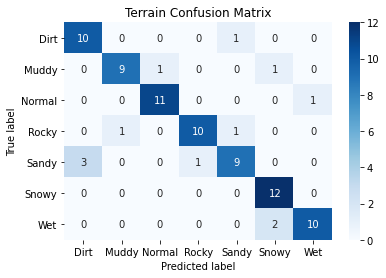

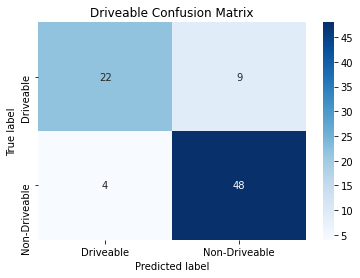

In [ ]:
# Plot confusion matrix
# model = SkyNet()
# checkpoint = torch.load("./Resnet18_model.pt")
# model.load_state_dict(checkpoint["model_state_dict"])
# model.eval()

target_vals_t = np.array([])
target_vals_d = np.array([])
predicted_vals_t = np.array([])
predicted_vals_d = np.array([])

print("Calculating predictions...")
with torch.no_grad():
        for data, target_t, target_d in test_loader:
          outputs_t, outputs_d = model(data)
          _, predicted_t = torch.max(outputs_t.data, 1)
          _, predicted_d = torch.max(outputs_d.data, 1)
          predicted_vals_t = np.concatenate([predicted_vals_t, predicted_t.tolist()])
          predicted_vals_d = np.concatenate([predicted_vals_d, predicted_d.tolist()])
          target_vals_t = np.concatenate([target_vals_t, target_t.tolist()])
          target_vals_d = np.concatenate([target_vals_d, target_d.tolist()])

print("Plotting confusion matrices...")
plot_confusion_matrix(target_vals_t, predicted_vals_t, "Terrain")
plot_confusion_matrix(target_vals_d, predicted_vals_d, "Driveable")

In [ ]:
# Print accuracy, precision, recall, f1
accuracy_t, precision_t, recall_t, f1_t = printStats(target_vals_t, predicted_vals_t, "Terrain")
accuracy_d, precision_d, recall_d, f1_d = printStats(target_vals_d, predicted_vals_d, "Driveable")

Terrain accuracy: 85.54216867469879
Terrain precision: 86.03230103230104
Terrain recall: 85.75591075591076
Terrain f1_score: 85.5023168687765
Driveable accuracy: 84.33734939759037
Driveable precision: 84.41295546558705
Driveable recall: 81.6377171215881
Driveable f1_score: 82.6331884757766


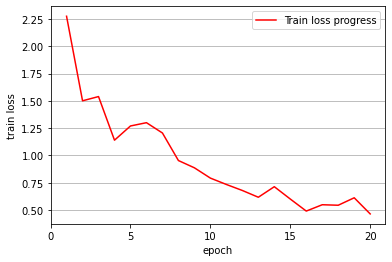

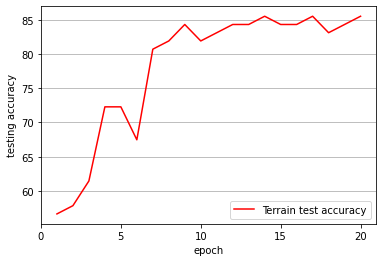

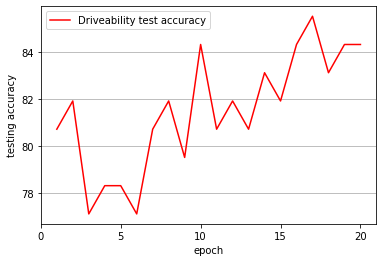

In [ ]:
# Plot train_loss_progress, test_accuracies_t, test_accuracies_d
plot_graph(train_loss_progress, "Train loss progress")
plot_graph(test_accuracies_t, "Terrain test accuracy")
plot_graph(test_accuracies_d, "Driveability test accuracy")

In [ ]:
# Save model
save_model_info(model, "Wide_resnet50_updated", train_loss_progress, test_accuracies_t, test_accuracies_d, accuracy_t, precision_t, recall_t, f1_t, accuracy_d, precision_d, recall_d, f1_d)

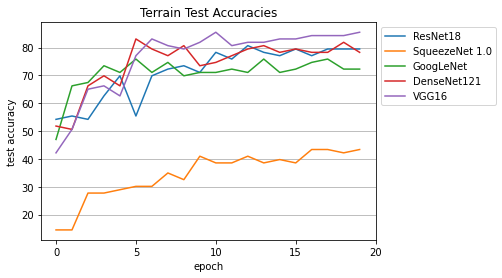

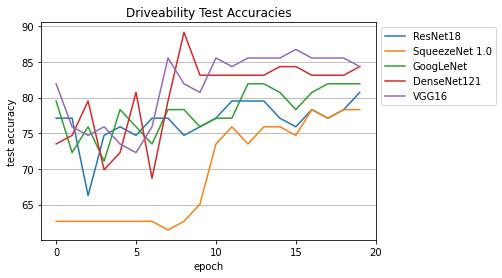

In [ ]:
resnet18_model = torch.load("Resnet18_updated_model.pt")
squeezenet_model = torch.load("Squeezenet_updated_model.pt")
googlenet_model = torch.load("Googlenet_updated_model.pt")
densenet121_model = torch.load("Densenet121_updated_model.pt")
resnext50_model = torch.load("Resnext50_updated_model.pt")
vgg16_model = torch.load("Vgg16_updated_model.pt")
wide_resnet50_model = torch.load("Wide_resnet50_updated_model.pt")


resnet18_test_acc_t = resnet18_model["test_accuracies_t"]
squeezenet_test_acc_t = squeezenet_model["test_accuracies_t"]
googlenet_test_acc_t = googlenet_model["test_accuracies_t"]
densenet121_test_acc_t = densenet121_model["test_accuracies_t"]
resnext50_test_acc_t = resnext50_model["test_accuracies_t"]
vgg16_test_acc_t = vgg16_model["test_accuracies_t"]
wide_resnet50_test_acc_t = wide_resnet50_model = torch.load("Wide_resnet50_updated_model.pt")["test_accuracies_t"]
compare_learning(resnet18_test_acc_t, squeezenet_test_acc_t, googlenet_test_acc_t, densenet121_test_acc_t, vgg16_test_acc_t, "Terrain Test Accuracies")


resnet18_test_acc_d = resnet18_model["test_accuracies_d"]
squeezenet_test_acc_d = squeezenet_model["test_accuracies_d"]
googlenet_test_acc_d = googlenet_model["test_accuracies_d"]
densenet121_test_acc_d = densenet121_model["test_accuracies_d"]
resnext50_test_acc_d = resnext50_model["test_accuracies_d"]
vgg16_test_acc_d = vgg16_model["test_accuracies_d"]
wide_resnet50_test_acc_d = wide_resnet50_model = torch.load("Wide_resnet50_updated_model.pt")["test_accuracies_d"]

compare_learning(resnet18_test_acc_d, squeezenet_test_acc_d, googlenet_test_acc_d, densenet121_test_acc_d, vgg16_test_acc_d, "Driveability Test Accuracies")